<a href="https://colab.research.google.com/github/Sim-mi-gyeong/DeepLearning/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
(train_ds, val_ds, test_ds), metadata=tfds.load("tf_flowers",  # 그래프에서 연산을 실행하는 데 필요한 관련된 metadata
                                                split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                with_info=True, 
                                                as_supervised=True,
                                                )

In [ ]:
num_classes=metadata.features['label'].num_classes
print(num_classes)

5


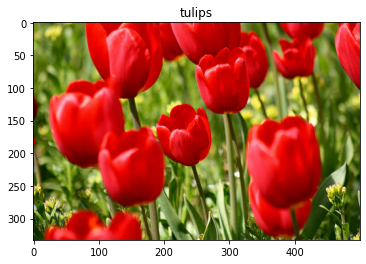

In [ ]:
get_label_name=metadata.features['label'].int2str
# next(iterator[, default]): (반복자에서 다음 항목을 반환. 기본값이 지정되고 반복기가 모두 사용되면 StopIteration을 올리는 대신 반환
image, label= next(iter(train_ds))
_=plt.imshow(image)
_=plt.title(get_label_name(label))

In [ ]:
# Keras 전처리 레이어 사용
# -> 현재 실험적 단계 Keras 전처리 레이어 사용
# -> 전처리 데이터 저장해놓고 쓰는 것이 아니라 계층 정의할 때 전처리 시도

In [ ]:
# 크기 및 배율 조정

IMG_SIZE=180

resize_and_rescale=tf.keras.Sequential([
                                        layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
                                        layers.experimental.preprocessing.Rescaling(1./255) 
])
# 배율 조정 레이어는 픽셀 값을 [0,1]로 표준화
# [-1,1]을 원할 경우, Rescaling(1./127.5, offset=-1)

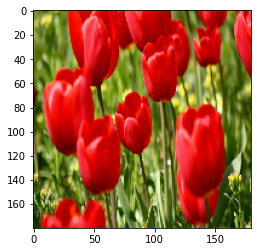

In [ ]:
result=resize_and_rescale(image)
_=plt.imshow(result)

In [ ]:
print("Min and max pixel values: ", result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


In [ ]:
# 데이터 증강
# -> 전처리 레이어 만들어 반복 적용
# 데이터 증강에 사용 가능한 전처리 레이어: layers.RandomContrast, layers.RandomCrop, layers.RandomZoom

In [ ]:
data_augmentation=tf.keras.Sequential([
                                        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# 이미지를 배치에 추가
image=tf.expand_dims(image,0)

In [ ]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

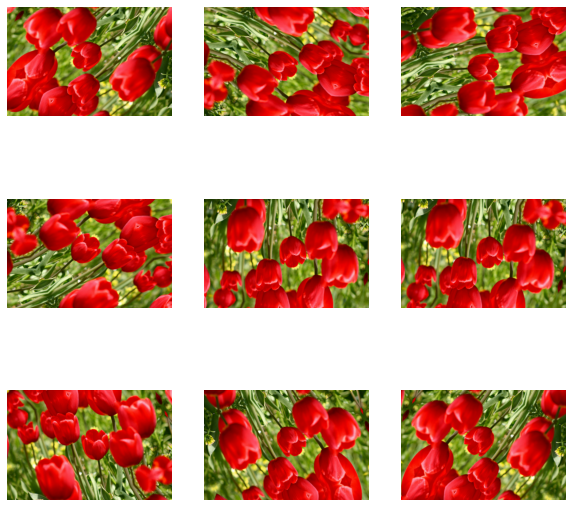

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image=data_augmentation(image)
  ax=plt.subplot(3,3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

In [ ]:
# 전처리 레이어 사용 두 가지 방법
# option1. 전처리 레이어를 모델의 일부로
# option2. 데이터세트에 전처리레이어 적용

In [ ]:
# option1. 전처리 레이어를 모델의 일부로

#model=tf.keras.Sequential([
#                           resize_and_rescale,
#                            data_augmentation,
#                            layers.Conv2D(16, 3, padding='same', activation='relu'),
#                            layers.MaxPooling2D(),

#])

In [ ]:
# data 증강: 나머지 레이어와 동기적으로 기기에서 실행, GPU 가속 이용
# model.save를 사용하여 모델 내보낼 때- 전처리 레이어가 모델 나머지 부분과 함께 저ㅏ장
                                    # -> 이 모젤 배포 시 레이어 구성에 따라 이미지 자동 표준화 -> 서버측 논리 다시 구현하지 않아도 됨
# 데이터 증강: 테스트 시 비활성화 -> 입력 이미지는 model.fit  호출 중에만 증강 -> model.evaluate/model.predict X

In [ ]:
# option2. 데이터세트에 전처리레이어 적용

aug_ds=train_ds.map(lambda x,y: (resize_and_rescale(x, training=True), y))

# Dataset.map -> 증강이미지 배치 생성하는 데이터 세트 만들기

In [ ]:
# data 증강=CPU에서 비동기적으로 이루어짐 -> 차단X
#                                         -> Dataset.preFetch(가져오기): GPU에서 모델 훈련을 데이터 전처리와 중첩 가능 
# 전처리 레이어=model.save 호출 시 모델과 함께 내보내지wl X -> 저장 전 레이어를 모델에 견결하거나 서버측에서 다시 구현 필요
#              -> 훈련 후 내보내기 전 전처리 레이어 연결 가능

In [ ]:
batch_size=32
AUTOTUNE=tf.data.experimental.AUTOTUNE  # tf.data 런타임이 실행 시에 동적으로 값을 조정

def prepare(ds, shuffle=False, augment=False):

  ds=ds.map(lambda x, y: (resize_and_rescale(x), y),
            num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds=ds.shuffle(1000)

  # Batch all datasets
  ds=ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds=ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
              # num_parallel_class=AUTOTUNE)
    
  # Use buffered prefecting on all datasets  
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds=prepare(train_ds, shuffle=True, augment=True)
val_ds=prepare(val_ds)
test_ds=prepare(test_ds)

In [ ]:
# 모델 훈련

model= tf.keras.Sequential([
                            layers.Conv2D(16,3, padding='same', activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Conv2D(32,3,padding='same', activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Conv2D(64,3, padding='same', activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(num_classes)
])

# filters: 몇 개의 다른 종류의 필터를 활용할 것인지를 나타냄. 출력 모양의 깊이(depth) 를 결정한다.
# kernel_size: 연산을 수행할 때 윈도우의 크기
# strides: 연산을 수행할 때 한 번에 얼마나 움직일지

In [ ]:
# 훈련 위해 모델 구성
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
# 희소 범주형 교차 엔트로피: 두 개 이상의 클래스가 있고 레이블이 정수인 경우
# from_logits=True: 모델의 출력값이 normalize 되는가(-> sigmoid(입력값 하나), linear) (false: 모델의 출력값이 해당 클래스 범위에서 확률 출력-> softmax(입력값 여러개-> 출력 확률 합=1))


In [ ]:
epochs=5
history=model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/5
92/92 [==============================] - 119s 1s/step - loss: 1.4934 - accuracy: 0.3437 - val_loss: 1.0926 - val_accuracy: 0.5586
Epoch 2/5
92/92 [==============================] - 114s 1s/step - loss: 1.0937 - accuracy: 0.5465 - val_loss: 1.1592 - val_accuracy: 0.5150
Epoch 3/5
92/92 [==============================] - 111s 1s/step - loss: 1.0563 - accuracy: 0.5714 - val_loss: 1.0365 - val_accuracy: 0.6022
Epoch 4/5
92/92 [==============================] - 108s 1s/step - loss: 0.9106 - accuracy: 0.6433 - val_loss: 0.9107 - val_accuracy: 0.6621
Epoch 5/5
92/92 [==============================] - 110s 1s/step - loss: 0.8785 - accuracy: 0.6609 - val_loss: 0.8994 - val_accuracy: 0.6322


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuract: ", acc)

12/12 [==============================] - 5s 355ms/step - loss: 0.8528 - accuracy: 0.6703
Accuract:  0.6702997088432312


In [ ]:
# 사용자 정의 데이터 증강
# layers.Lambda 레이어 생성
# sub class 생성

In [ ]:
def random_invert_img(x, p=0.5):
  if tf.random.uniform([]) <p:  # random함수로 균일분포 난수 발생ef random_invert_img(x, p=0.5):
      if tf.random.uniform([]) <p:  # random함수로 균일분포 난수 발생
          x=(255-x)
      else:
          x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert=random_invert()

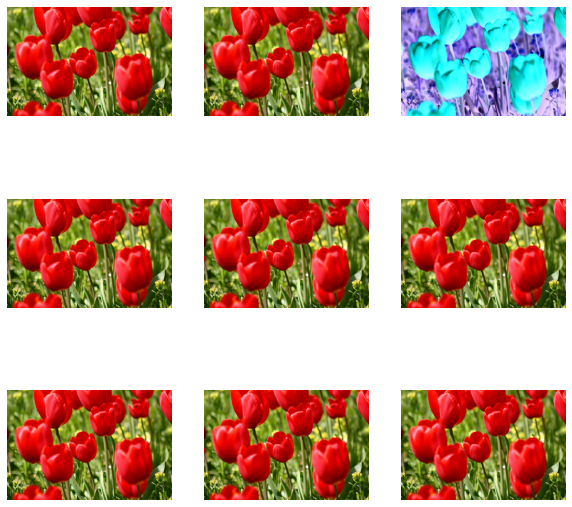

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image=random_invert(image)
  ax=plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis("off")

In [ ]:
# sub class 생성을 통한 사용자 정의 레이어 구현

class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor=factor

  def call(self, x):
    return random_invert_img(x)

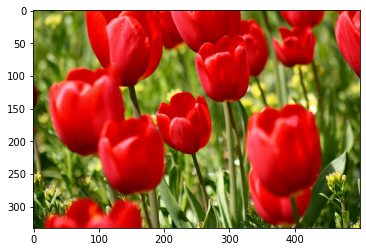

In [ ]:
_=plt.imshow(RandomInvert()(image)[0])

In [ ]:
# tf.image 사용하기
# -> layers.preprocessing 보다 세밀한 제어-> tf.data, tf.image: 고유 데이터 증강 파이프라인, 레이어 작성 가능

In [ ]:
# 꽃 data set이 이전에 데이터 증강으로 구성 -> 다시 가져와 시작